In [169]:
using JuMP, Gurobi, Random, CSV, DataFrames, Statistics, JLD2, FileIO, DelimitedFiles

model_type="model_without_k";
include("scripts/"*model_type*"/display.jl")
include("scripts/"*model_type*"/model.jl");
include("scripts/"*model_type*"/run.jl");
include("data/map_inputs.jl");

### Inputs

In [158]:
# Map Inputs
map_type="clust_map_1";

# Model Inputs
benchmark=false;
park_slots=3; # max nb parking slots at each hub location
G = 2 # max detour ratio for customers (traveling time < (1+G)gamma)
Gtype= "shortestpathpercent" # or "absolutetime"

if benchmark
    Q = 1 # vehicle capacity;
else
    Q = 10
end

map_inputs,Wk=create_inputs(map_type);
(map_title,hubs_id,vbs_id,nb_locs,cust_id,nb_cust,depot_locs,horizon,tstep)=map_inputs;
model_inputs = (G,Gtype,Wk,Q);

### Display map & create network

In [159]:
data, map1, tsnetwork, params, abbrev = create_network(map_inputs, model_inputs,benchmark,park_slots);
q, t, I, K=abbrev;

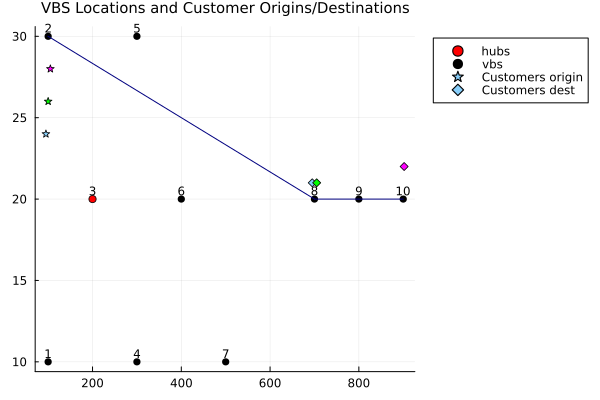

Cust 1, load 1 - Pick-up vbs: [1, 2], Drop-off vbs: [8], 	 depart at: 0.0, arrival before: 11000.0
Cust 2, load 1 - Pick-up vbs: [1, 2], Drop-off vbs: [8], 	 depart at: 0.0, arrival before: 11000.0
Cust 3, load 1 - Pick-up vbs: [2], Drop-off vbs: [10], 	 depart at: 0.0, arrival before: 12500
Bus depot locations: [1, 2, 1, 7, 8, 1, 2, 1, 7, 8]

In [160]:
# Show map
display(map1)
print_cust_bus_details(params,abbrev,depot_locs)

In [133]:
# Print number of nodes and arcs
#print_nb_arcs(tsnetwork,params,I)


In [134]:
# To visualize some arcs
#timespaceviz_arcs("viz.png", horizon, tstep, tsnetwork, tsnetwork.A_plus[56],data.locs_id,data.locs_desc, x_size=2000, y_size=1000)

### Run model & Save results

In [142]:
# Model objective coefficients
mu=1 # coefficient in front of walking time
beta=1 # coefficient in front of waiting time
lambda=1 # transfer penalty
alpha1=0.01 # coefficient in front of vehicle driving time and utilization 
nu=20 # coefficient in front of vehicle utilization
alpha2=0 # coefficient in front of unmet demand
coefficients=mu,beta,lambda,alpha1,nu,alpha2;

In [155]:
sol=network_model(Q,abbrev,data.wo,tsnetwork,params,coefficients,0);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Objective value: 11697.76910578736


Save solution

In [156]:
save_res = true; # to save the results in the result folder

if save_res
    if benchmark
        resultfolder="results/"*model_type*"/benchmark/"*map_type*"/";
    else
        resultfolder="results/"*model_type*"/"*map_type*"/";
    end
    resultfile=resultfolder*"Q"*string(Q)*"_Wk"*string(Wk)
    
    if !isdir(resultfolder)
        mkdir(resultfolder)
    end
    jldsave(resultfile*".jld2", xi=sol.xi, x=sol.x, z=sol.z)
    write_result(resultfile,sol,tsnetwork,params,abbrev,data.wo,data.locs_id,false)
end

### Visualizations

In [42]:
#xi,x,z=load(resultfile*".jld2", "xi", "x", "z");

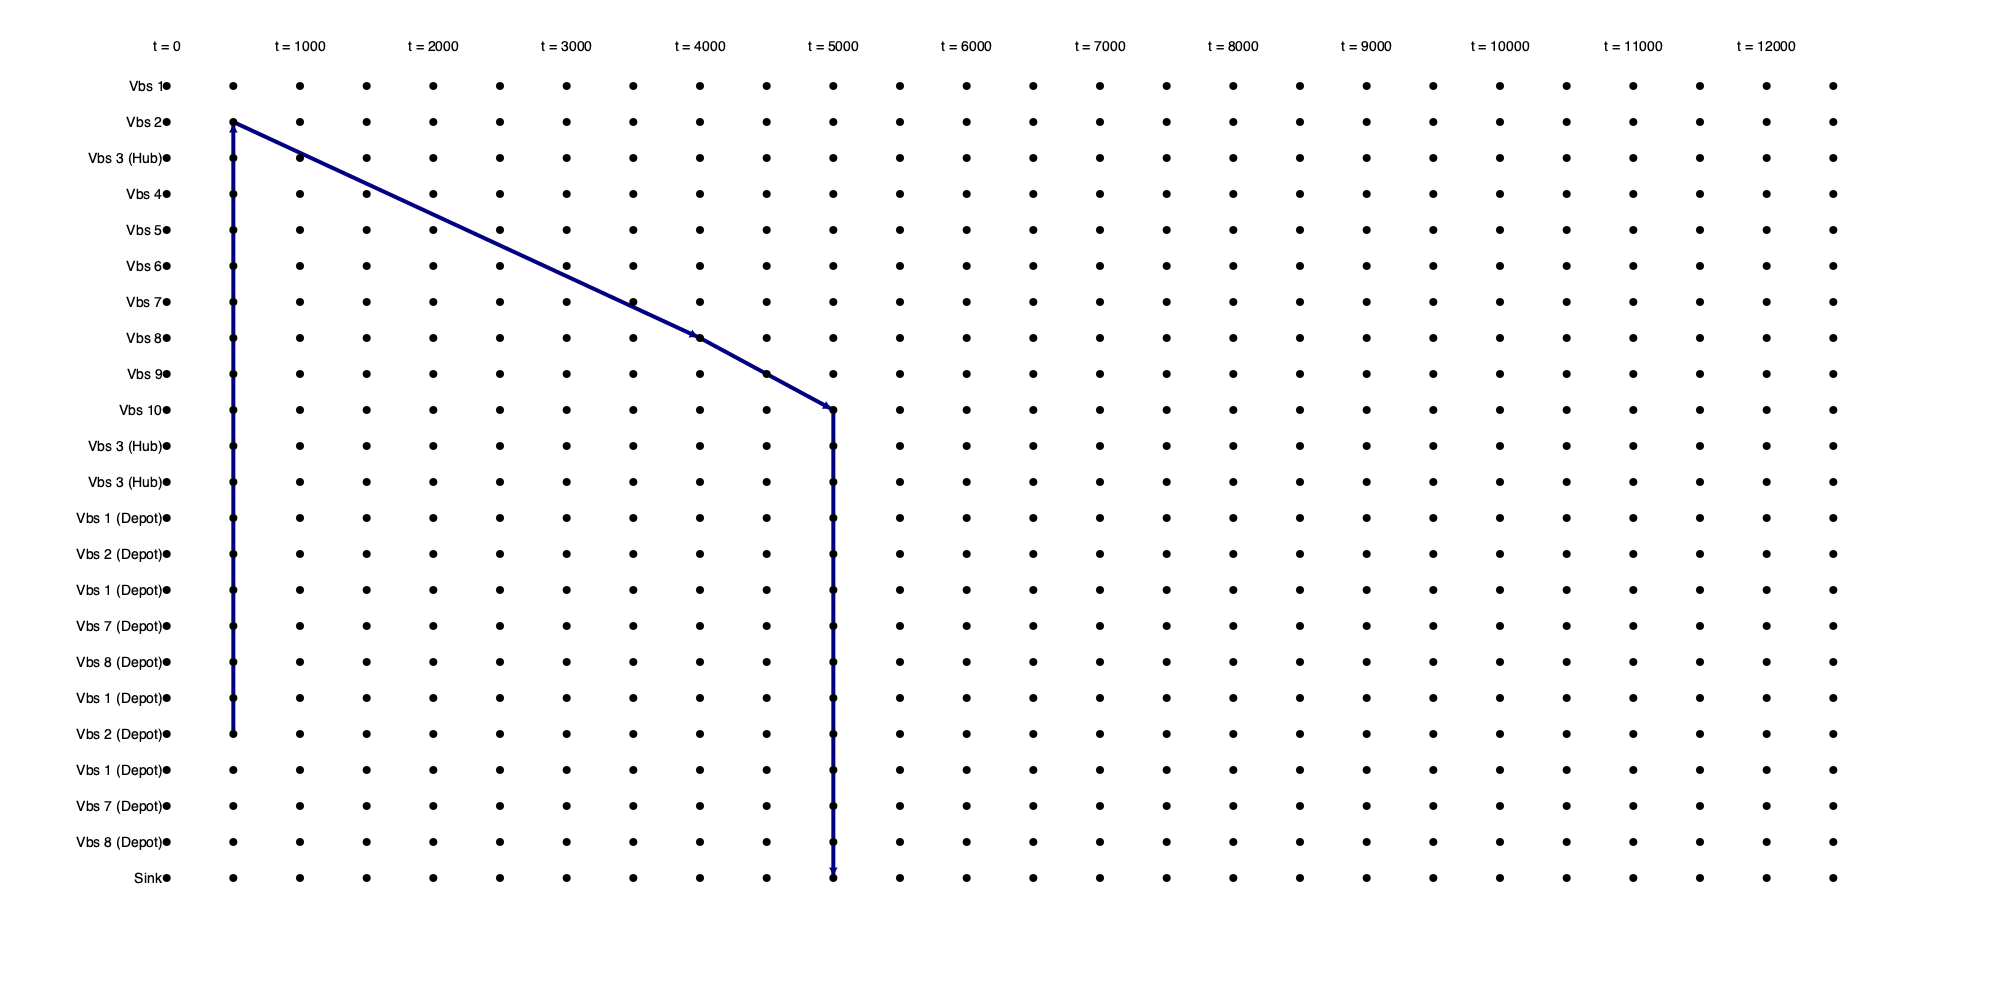

In [148]:
timespaceviz_bus(resultfile*"_tsplot.png", horizon, tstep, tsnetwork, params, sol.z, data.locs_id, x_size=2000, y_size=1000)

Traveling arcs used:
-- Bus 1: 
-- Bus 2: 
-- Bus 3: 
-- Bus 4: 
-- Bus 5: 
-- Bus 6: 
-- Bus 7: 


	 Time 500: Vbs 2 (Depot) --> Vbs 2
	 Time 500: Vbs 2 --> Vbs 8, with cust [1, 2, 3]


	 Time 4000: Vbs 8 --> Vbs 10, with cust [3]
	 Time 5000: Vbs 10 --> Sink


-- Bus 8: 
-- Bus 9: 
-- Bus 10: 


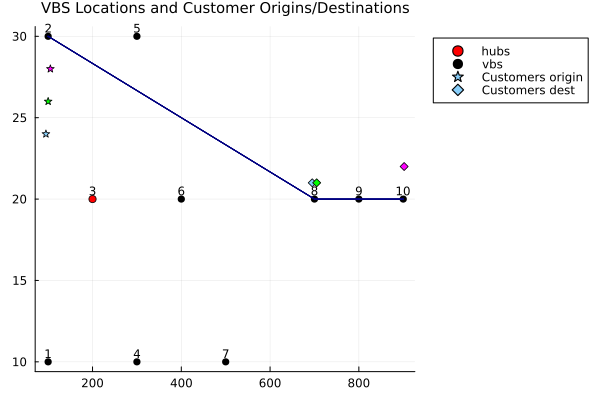

In [170]:
ts=0 # time from which we want to print the arcs
map2=print_traveling_arcs(sol,ts,map1,data.locs,tsnetwork,params,data.locs_id,data.locs_desc,true,save_res,resultfile)